<h1> Lunar Landing Environment. Data Exploration </h1>

# TODO
1. Summary Statistics (comment on the results)
2. Univariate Analysis (Single Variable) (comment on the results)
3. Bivariate Analysis (Relationships)
    * Correlation Matrices
    * Scatter plots for continuous variables
4. Feature Engineering 
    * Create new variables if necessary
    * Transform variables (log, sqrt, etc.)
5. Detect and Handle Outliers
    * use boxplots or z-score
    * decide whether to transform or remove them
6. Data Visualization

<h3> Environment: <a href="https://gymnasium.farama.org/environments/box2d/lunar_lander/"> Lunar Lander v2  </a> </h3>

* Classic rocket trajectory optimization problem
* <b>Discrete actions:</b> engine <b>on</b> or <b>off</b> 
    * (Pontryagin’s maximum principle => it is optimal to fire the engine at full throttle or turn it off)
* <b>Two environment versions:</b> discrete or continuous (discrete in our case)
* <b> Fuel is infinite </b> => the agent can learn to fly and then land on its first attempt


<h3> States </h3>

*   8-dimensional vectors:
    * [0]: x coordinate
    * [1]: y coordinate
    * [2]: linear velocity in x
    * [3]: linear velocity in y
    * [4]: Lander`s angle
    * [5]: Lander`s angular velocity
    * [6]: Leg 1 contacts the land (boolean)
    * [7]: Leg 2 contacts the land (boolean)

*   <b> Initial State:</b>
    * <b>x, y:</b> starts at the top center of the viewport
    * random initial force applied to its center of mass.

<h3> Action Space </h3>

* 0: do nothing
* 1: fire left orientation engine
* 2: fire main engine
* 3: fire right orientation engine

<h3> Rewards </h3>
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each timestep, the reward:
* is increased/decreased the closer/further the lander is to the landing pad.
* is increased/decreased the slower/faster the lander is moving.
* is decreased the more the lander is tilted (angle not horizontal).
* +10 points for each leg that is in contact with the ground.
* -0.03 points each frame a side engine is firing.
* -0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

In [1]:

# navigates to the main project folder
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from src.utils.data_loading import *
from src.utils.plotting import *

import gymnasium as gym
from gymnasium.envs.registration import register

<h2> Loading the data </h2>

In [3]:
# works also for 'final_policy.npz'
rb_observations, rb_next_observations, rb_actions, rb_rewards, rb_dones = load_data()
fp_observations, fp_next_observations, fp_actions, fp_rewards, fp_dones = load_data('../data/final_policy.npz')
rb_df = load_data_as_df(rb_observations, rb_next_observations, rb_actions, rb_rewards, rb_dones)
fp_df = load_data_as_df(fp_observations, fp_next_observations, fp_actions, fp_rewards, fp_dones)

In [4]:
rb_df

,X,Y,lv_X,lv_Y,angle,angular_velocity,leg_1,leg_2,action,reward,done,next_X,next_Y,next_lv_X,next_lv_Y,next_angle,next_angular_velocity,next_leg_1,next_leg_2
0,-0.004820,1.401093,-0.488218,-0.436776,0.005592,0.110589,False,False,0,-1.197077,False,-0.009640,1.390689,-0.487559,-0.462411,0.011056,0.109301,False,False
1,-0.009640,1.390689,-0.487559,-0.462411,0.011056,0.109301,False,False,1,-2.399095,False,-0.014555,1.379694,-0.499388,-0.488779,0.018885,0.156586,False,False
2,-0.014555,1.379694,-0.499388,-0.488779,0.018885,0.156586,False,False,3,-0.752683,False,-0.019400,1.368104,-0.490665,-0.515199,0.024956,0.121428,False,False
3,-0.019400,1.368104,-0.490665,-0.515199,0.024956,0.121428,False,False,2,3.208104,False,-0.024134,1.357258,-0.480146,-0.482138,0.031669,0.134276,False,False
4,-0.024134,1.357258,-0.480146,-0.482138,0.031669,0.134276,False,False,3,-0.579223,False,-0.028784,1.345807,-0.469743,-0.509043,0.036294,0.092512,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.493834,0.679598,-0.104434,-0.052801,-0.010288,-0.005370,False,False,2,1.965186,False,0.492889,0.679355,-0.094666,-0.010779,-0.010133,0.003098,False,False
999996,0.492889,0.679355,-0.094666,-0.010779,-0.010133,0.003098,False,False,0,-0.513342,False,0.491943,0.678513,-0.094666,-0.037446,-0.009978,0.003098,False,False
999997,0.491943,0.678513,-0.094666,-0.037446,-0.009978,0.003098,False,False,0,-1.065271,False,0.490998,0.677070,-0.094666,-0.064113,-0.009823,0.003098,False,False
999998,0.490998,0.677070,-0.094666,-0.064113,-0.009823,0.003098,False,False,2,1.672107,False,0.490164,0.676000,-0.084105,-0.047529,-0.009186,0.012742,False,False


In [5]:
fp_df

,X,Y,lv_X,lv_Y,angle,angular_velocity,leg_1,leg_2,action,reward,done,next_X,next_Y,next_lv_X,next_lv_Y,next_angle,next_angular_velocity,next_leg_1,next_leg_2
0,-0.004458,1.417225,-0.451546,0.280229,0.005172,0.102282,False,False,0,0.282169,False,-0.008916,1.422953,-0.450936,0.254527,0.010227,0.101095,False,False
1,-0.008916,1.422953,-0.450936,0.254527,0.010227,0.101095,False,False,0,0.233084,False,-0.013375,1.428082,-0.450951,0.227893,0.015278,0.101034,False,False
2,-0.013375,1.428082,-0.450951,0.227893,0.015278,0.101034,False,False,0,0.181481,False,-0.017833,1.432610,-0.450966,0.201220,0.020328,0.101021,False,False
3,-0.017833,1.432610,-0.450966,0.201220,0.020328,0.101021,False,False,0,0.119917,False,-0.022292,1.436539,-0.450981,0.174550,0.025378,0.101005,False,False
4,-0.022292,1.436539,-0.450981,0.174550,0.025378,0.101005,False,False,0,0.050642,False,-0.026751,1.439869,-0.450996,0.147880,0.030427,0.100989,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.138625,0.395640,0.019981,-0.013554,-0.026739,0.012687,False,False,0,-1.920943,False,-0.138419,0.394735,0.019981,-0.040221,-0.026104,0.012687,False,False
999996,-0.138419,0.394735,0.019981,-0.040221,-0.026104,0.012687,False,False,2,0.216812,False,-0.138371,0.393831,0.004981,-0.040159,-0.026249,-0.002887,False,False
999997,-0.138371,0.393831,0.004981,-0.040159,-0.026249,-0.002887,False,False,2,-0.037548,False,-0.138228,0.393015,0.013994,-0.036290,-0.026014,0.004691,False,False
999998,-0.138228,0.393015,0.013994,-0.036290,-0.026014,0.004691,False,False,2,1.175867,False,-0.137975,0.392930,0.024653,-0.003769,-0.025375,0.012790,False,False


In [6]:
# minimal example for creating the correct environment
# Register the deprecated environment manually
register(
    id="LunarLander-v2",
    entry_point="gymnasium.envs.box2d:LunarLander",
    max_episode_steps=1000,
    reward_threshold=200,
)

# Separate env for evaluation
env = gym.make("LunarLander-v2")

c:\Users\miroa\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment LunarLander-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


<h2> Descriptive Statistics </h2>

# Comment on these stats for rb and fp

In [7]:
rb_df.describe()

,X,Y,lv_X,lv_Y,angle,angular_velocity,action,reward,next_X,next_Y,next_lv_X,next_lv_Y,next_angle,next_angular_velocity
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.001781,0.626424,-0.005798,-0.086050,0.002959,0.000359,1.486163,-0.181394,0.001722,0.624482,-0.005876,-0.086282,0.002975,0.000255
std,0.315183,0.392150,0.261894,0.189206,0.142534,0.097794,0.975601,3.505517,0.316042,0.391319,0.262345,0.189275,0.144908,0.124783
min,-0.999973,-0.329198,-3.130971,-3.490214,-3.475823,-6.078868,0.000000,-100.000000,-1.022185,-0.345251,-3.130971,-3.490214,-3.475823,-6.835131
25%,-0.176169,0.285537,-0.094518,-0.100592,-0.035829,-0.025641,0.000000,-1.170975,-0.176709,0.284983,-0.094424,-0.100529,-0.035955,-0.025616
50%,0.014599,0.544233,0.012129,-0.042499,0.003954,-0.000473,2.000000,-0.151606,0.015106,0.542607,0.012105,-0.042475,0.003996,-0.000472
75%,0.188611,0.914561,0.102217,-0.004879,0.039444,0.024413,2.000000,0.893822,0.189062,0.911549,0.102079,-0.004902,0.039532,0.024387
max,0.999957,3.649655,3.295701,0.830236,3.603545,6.082865,3.000000,135.202332,1.030535,3.651300,3.295701,0.830236,3.689763,6.243361


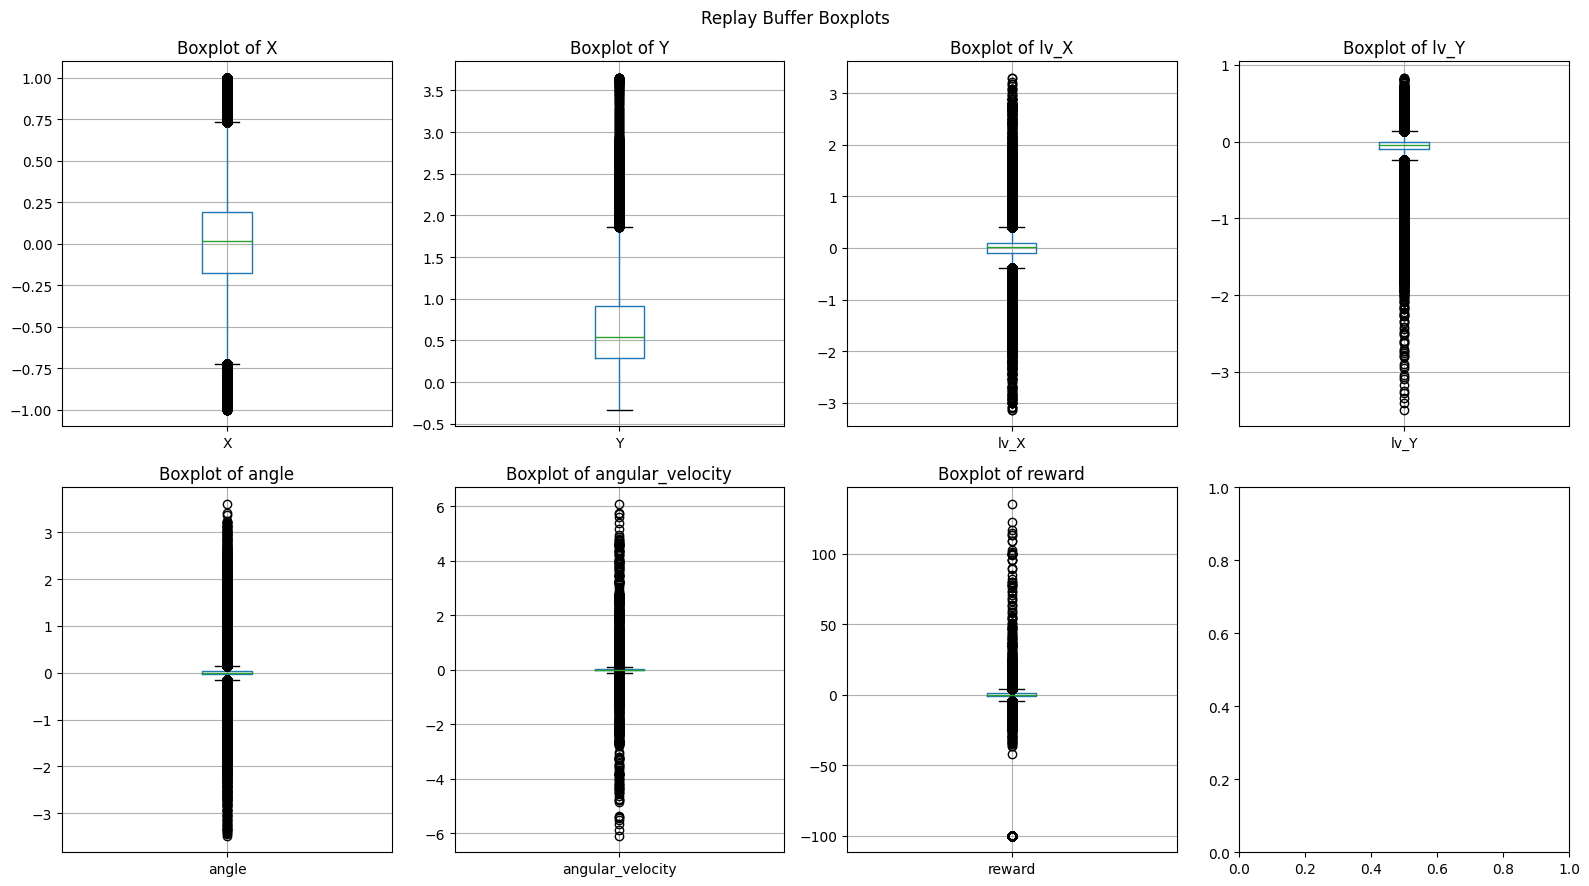

In [8]:
rb_boxplots_fig = plot_boxplots_df(data=rb_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'reward']], custom_title='Replay Buffer Boxplots')
plt.show(rb_boxplots_fig)

In [9]:
fp_df.describe()

,X,Y,lv_X,lv_Y,angle,angular_velocity,action,reward,next_X,next_Y,next_lv_X,next_lv_Y,next_angle,next_angular_velocity
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,-0.037111,0.457659,-0.022127,-0.073641,-0.000956,-4.988660e-04,1.303731,0.099499,-0.037333,0.456002,-0.022247,-0.073637,-0.000981,-4.989852e-04
std,0.285953,0.366363,0.207260,0.089138,0.058972,4.295013e-02,1.004141,3.437879,0.286221,0.365113,0.206805,0.088486,0.059064,4.284771e-02
min,-0.999958,-0.220163,-1.136813,-0.621478,-0.695194,-1.057240e+00,0.000000,-100.000000,-1.010388,-0.220163,-1.136813,-0.621478,-0.695194,-1.057240e+00
25%,-0.182890,0.163690,-0.077555,-0.104373,-0.032723,-2.057063e-02,0.000000,-1.123568,-0.183038,0.162920,-0.077314,-0.104256,-0.032767,-2.054164e-02
50%,-0.076541,0.363006,0.003732,-0.053853,0.002140,-3.587462e-07,2.000000,-0.080574,-0.076764,0.361759,0.003635,-0.053782,0.002125,-2.937315e-07
75%,0.046390,0.690622,0.066292,-0.015806,0.034512,2.028757e-02,2.000000,1.101930,0.046453,0.688720,0.066132,-0.015747,0.034520,2.024486e-02
max,0.999992,1.528019,0.831265,0.510804,0.423147,8.881481e-01,3.000000,100.000000,1.000315,1.528019,0.831265,0.485024,0.464000,8.881481e-01


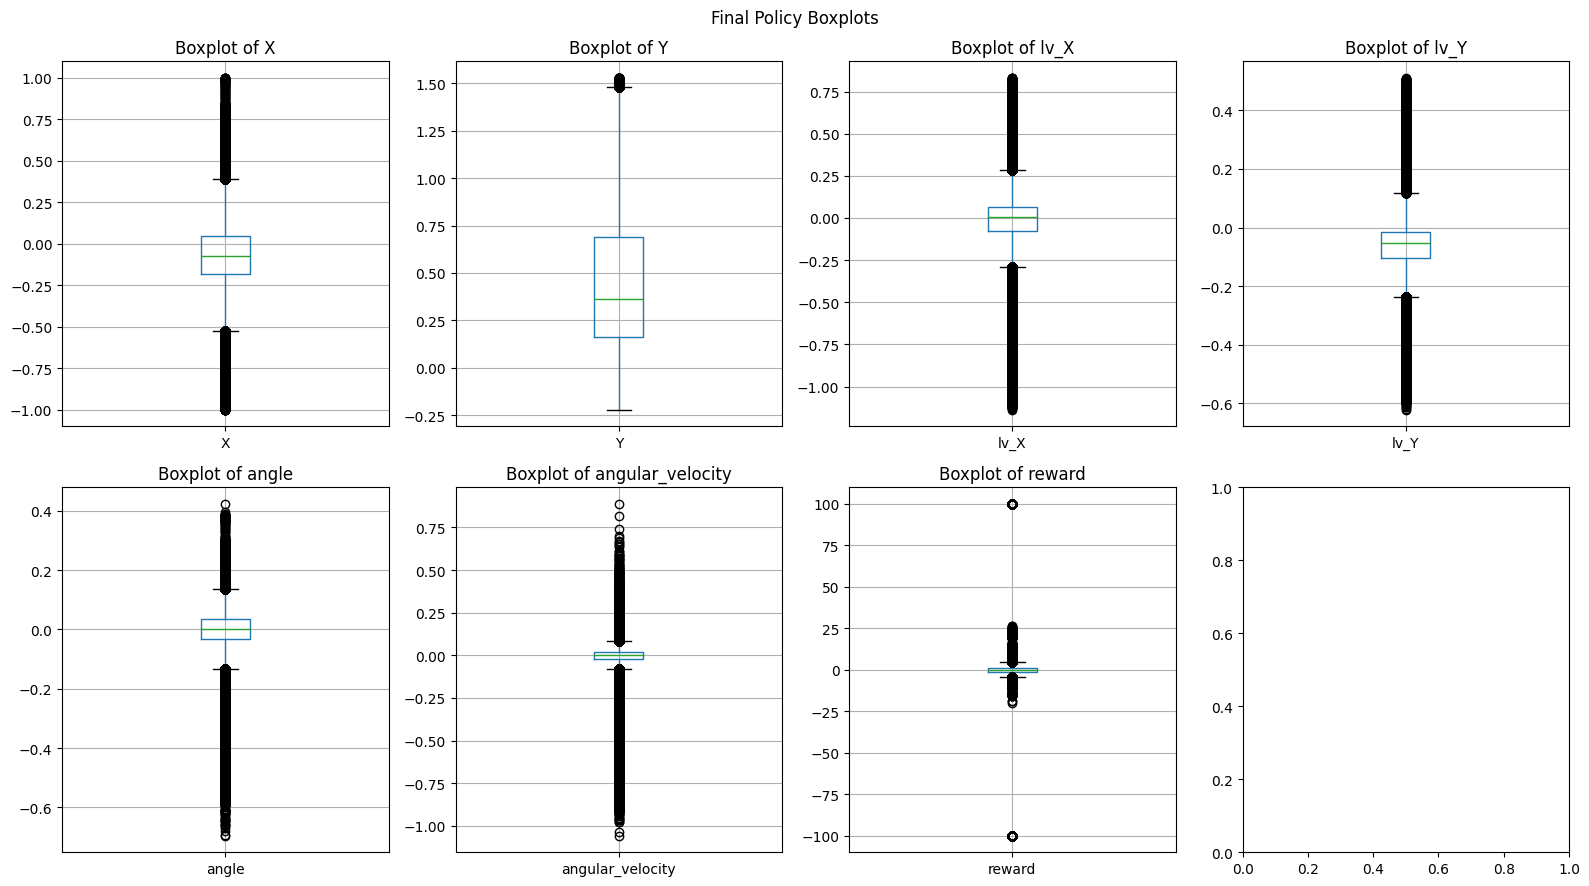

In [10]:
fp_boxplots_fig = plot_boxplots_df(data=fp_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'reward']], custom_title='Final Policy Boxplots')
plt.show(fp_boxplots_fig)

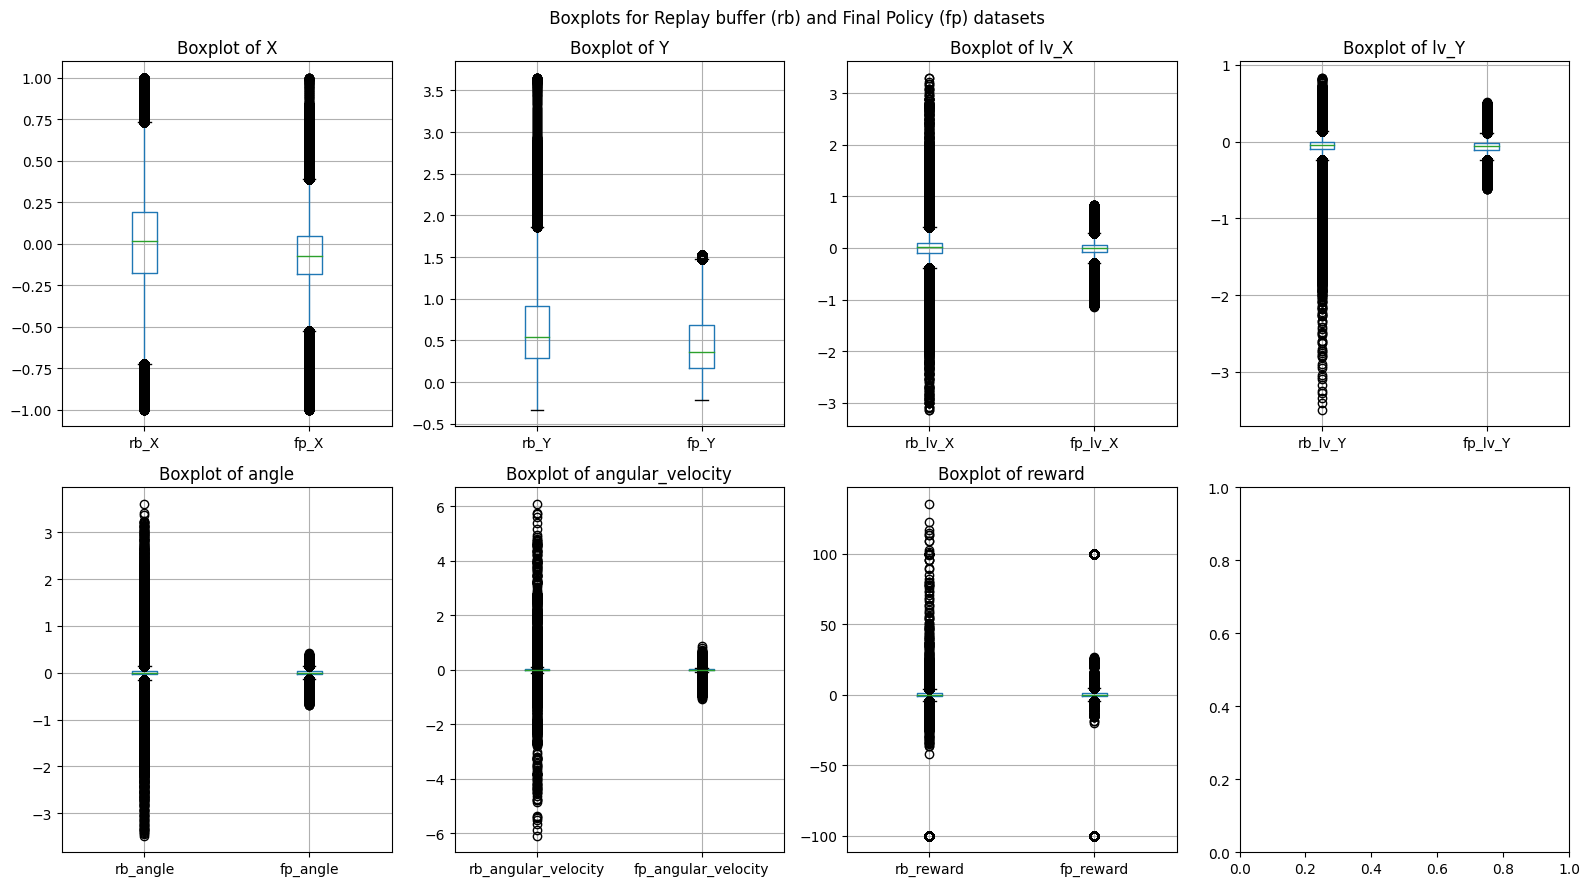

In [11]:
rb_fp_boxplots_combined_fig = plot_boxplots_compare_df(
        df1_name = 'rb',
        df2_name = 'fp',
        df1=rb_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'reward']],
        df2=fp_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'reward']],
        num_columns=4,
        custom_title=' Boxplots for Replay buffer (rb) and Final Policy (fp) datasets')
#plt.show(rb_fp_boxplots_combined_fig)

<h2> Univariate Analysis </h2>

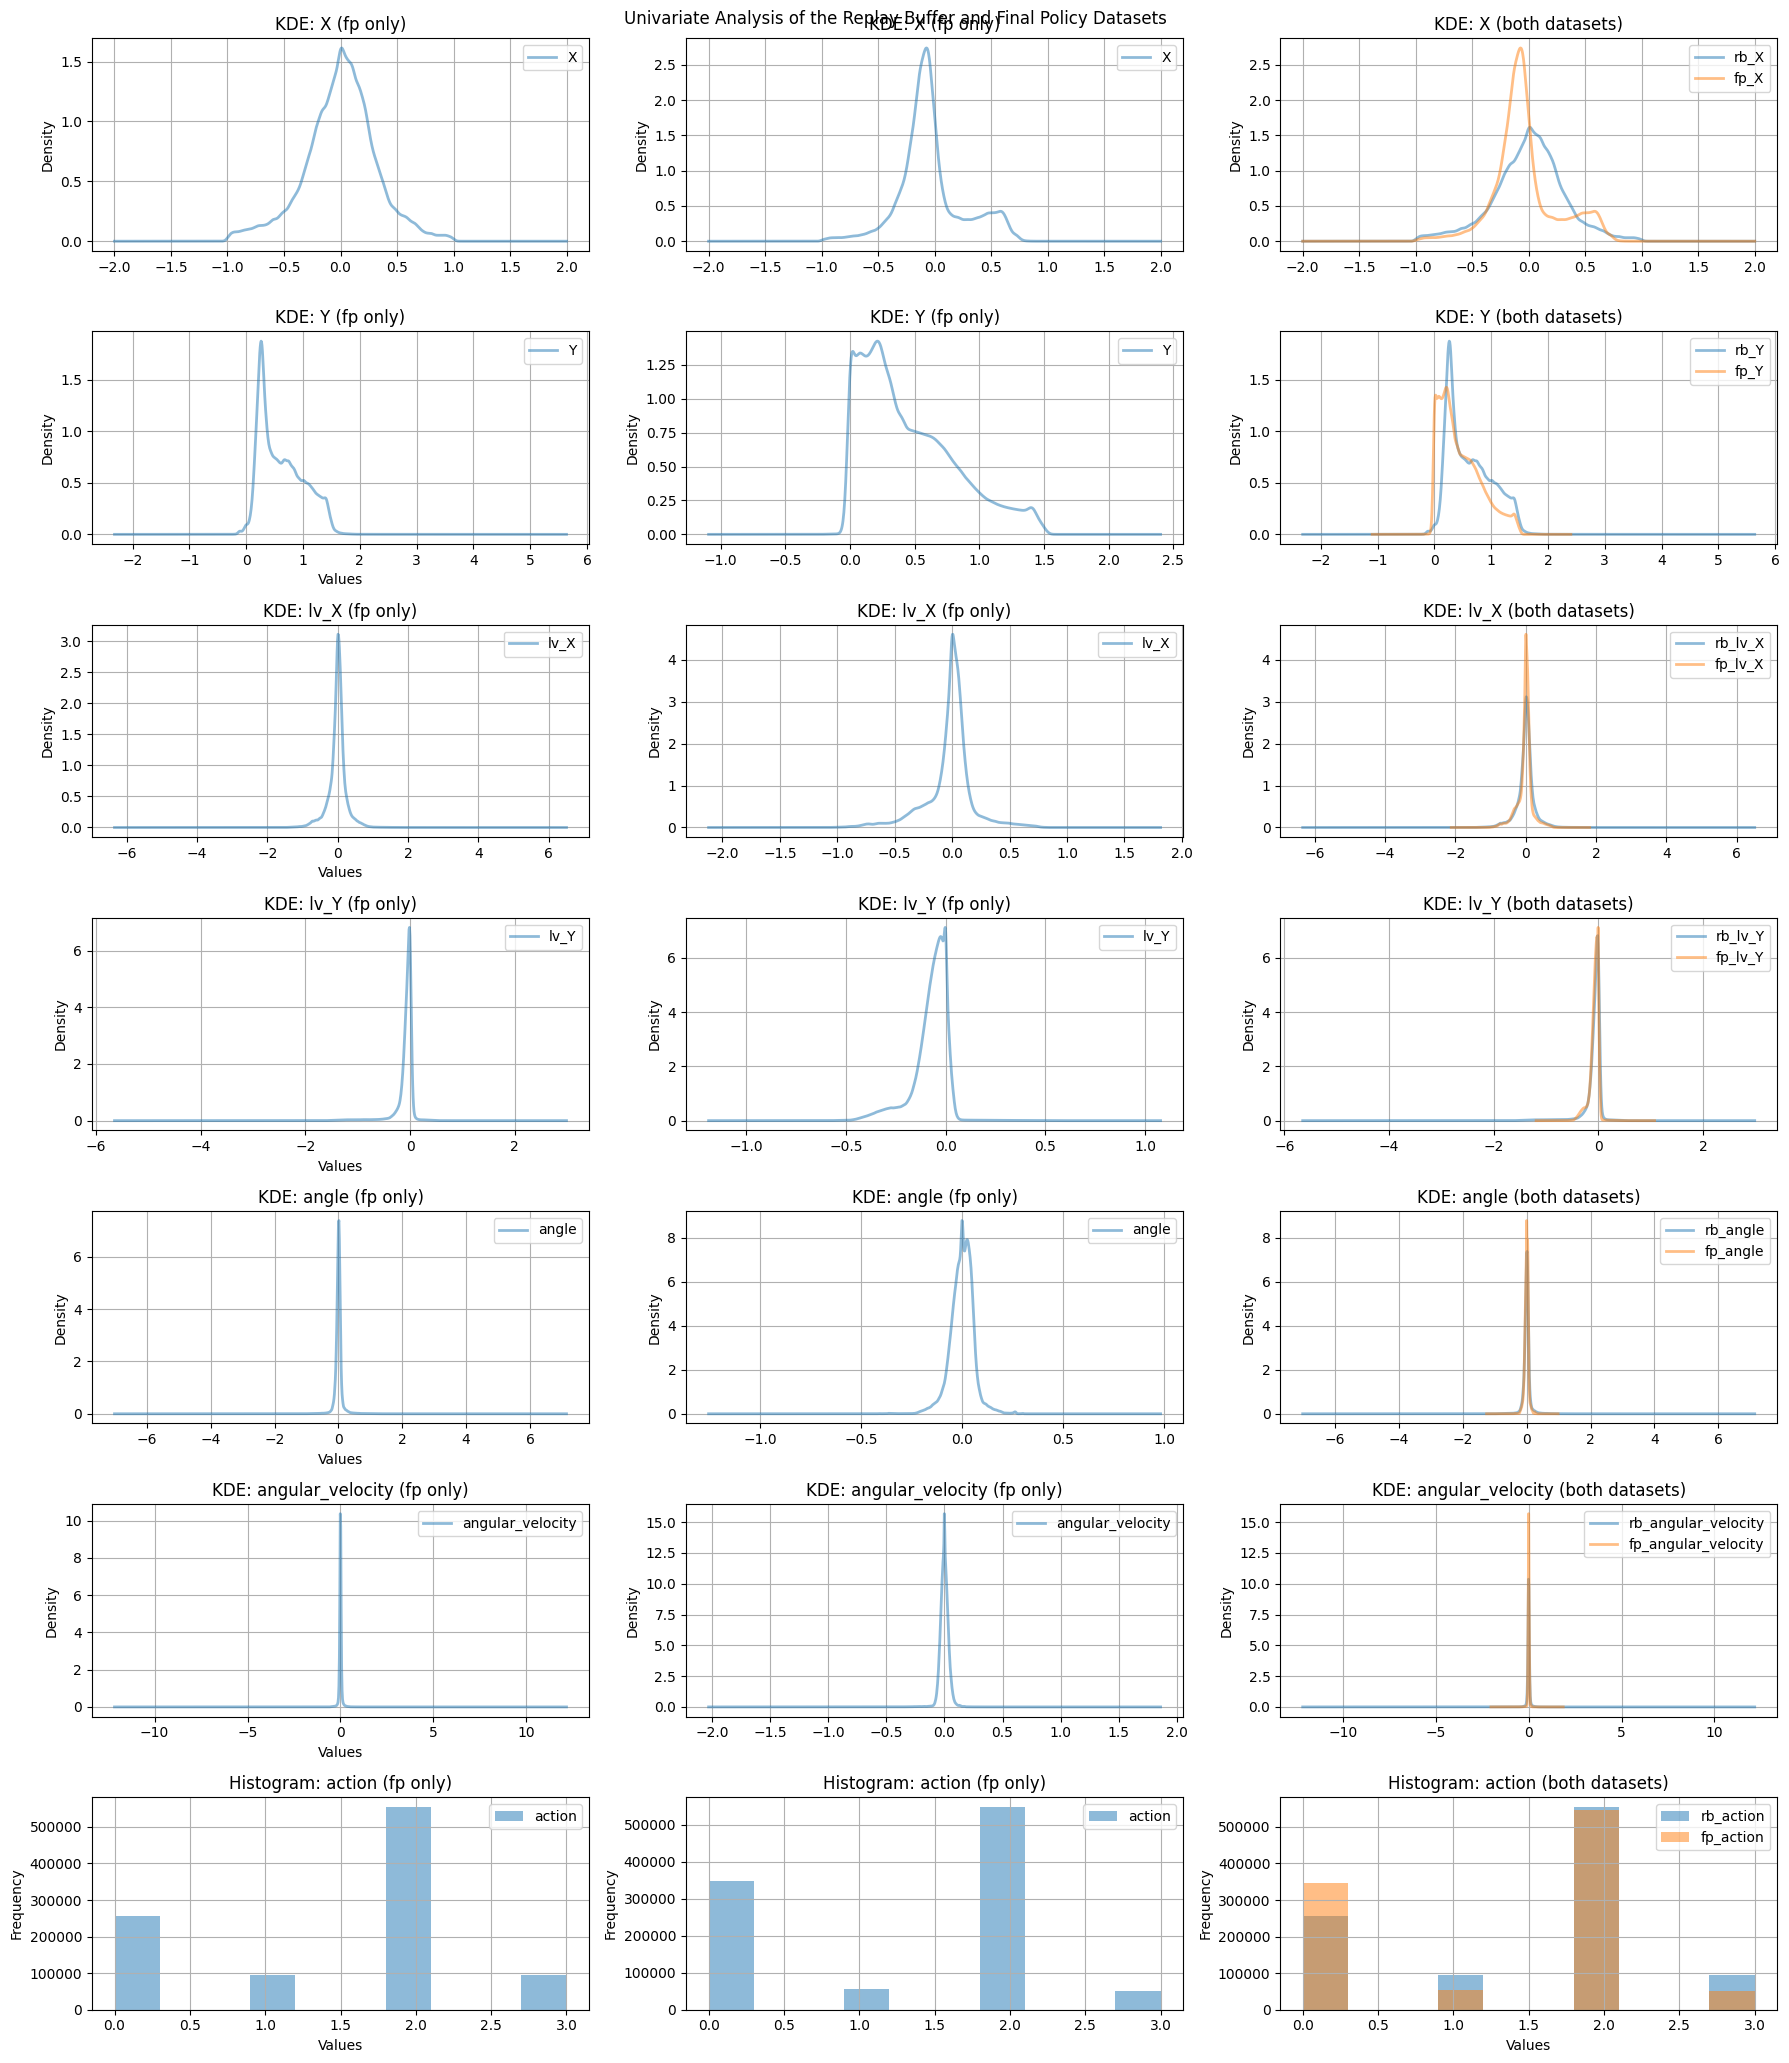

In [ ]:
rb_fp_univar_fig = plot_univariate_analysis(
        df1_name = 'rb',
        df2_name = 'fp',
        df1=rb_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'action']],
        df2=fp_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'action']],
        num_columns=3,
        custom_title='Univariate Analysis of the Replay Buffer and Final Policy Datasets',
        kde_kwargs={'linewidth': 2, 'alpha': 0.5, 'grid': True},
        hist_kwargs={'alpha': 0.5, 'grid': True, 'bins': [-0.5, 0.5, 1.5, 2.5, 3.5],'align':'mid', 'rwidth': 0.8},
        f_size=(21,21))

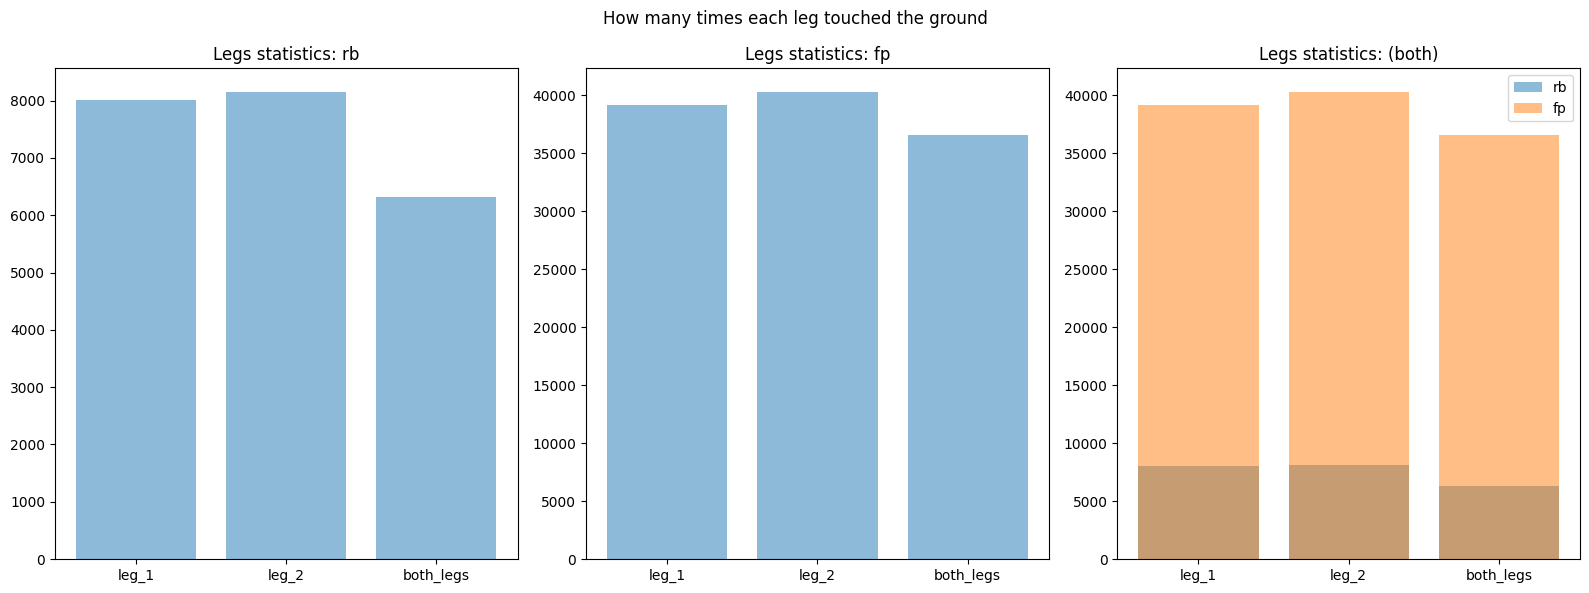

In [43]:
rb_legs_df = get_legs_df(rb_df)
fp_legs_df = get_legs_df(fp_df)

legs_fig = plot_legs_bar(rb_legs_df, fp_legs_df, df1_name='rb', df2_name='fp',
                        custom_title = 'How many times each leg touched the ground', bar_kwargs={'alpha': 0.5})

<h2> Multivariate Analysis </h2>

* XY coordinate env exploration

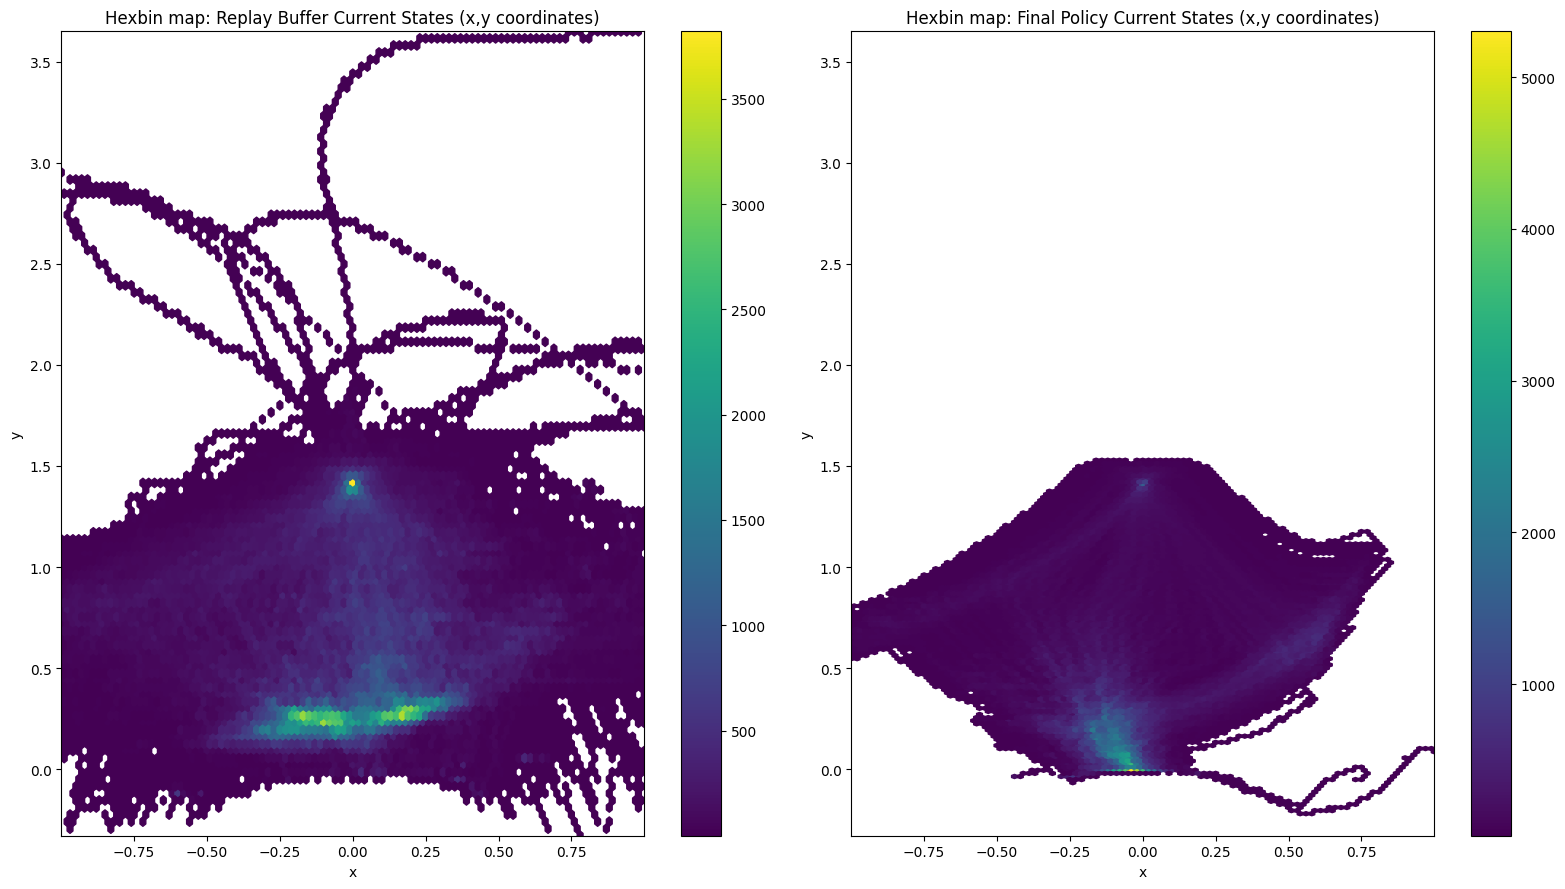

In [ ]:
xy_hexbin_fig = plot_hexbin(data_dict={'Replay Buffer States (x,y coordinates)': rb_df[['X', 'Y']].to_numpy(),
                                       'Final Policy States (x,y coordinates)': fp_df[['X', 'Y']].to_numpy()})

* xy velocity

In [57]:
def quiver_plot_lvs(df1: pd.DataFrame, df2: pd.DataFrame, df1_name: str = 'Dataset 1', df2_name: str = 'Dataset 2',
        custom_title: str = 'Quiver Plot', f_size: tuple = (16,6), qiver_kwargs: dict = {}) -> plt.Figure:
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=f_size)
    axes = axes.flatten()
    
    axes[0].quiver(df1[['X']].to_numpy(), df1[['Y']].to_numpy(), 
                df1[['lv_X']].to_numpy(), df1[['lv_Y']].to_numpy(),
                **qiver_kwargs)
    
    axes[1].quiver(df2[['X']].to_numpy(), df2[['Y']].to_numpy(), 
            df2[['lv_X']].to_numpy(), df2[['lv_Y']].to_numpy(),
            **qiver_kwargs)
    
    fig.tight_layout()
    return fig